In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint, uniform

In [2]:
# test ok

# measure the difference between matrices, and the relative error
def mat_div(m1, m2):
    return np.sum((m1 - m2) ** 2)

def mat_div_relative(m1, m2):
    return mat_div(m1, m2) / mat_div(m1, np.zeros(m1.shape))

def relative_error(a, b):
    return np.abs(a - b) / a

In [3]:
# parameters in the simulation

# parameters in the Hubbard model
U = 8.0
beta = 4

# Parameters about the lattice
# $L$ is required to be even to enable the checkboard decomposition
L = 4

# parameters about the simulation
dtau = 0.05
n_sweep = 400
# 多久做一次UDV计算；必须整除n_imtime
n_wrap = 10

# Parameters and initialization

In [4]:
# test ok

# 衍生的参数，以及必要的初始化

# 总的site数目
n_site = L ** 2
# 虚时间点数目
n_imtime = int(beta / dtau)
# alpha值，用于计算相互作用哈密顿量
alpha = np.arccosh(np.exp(dtau * U / 2))
# 辅助场时间线，第一个维度是虚时间点，第二个维度是site；使用编号（而不是xy坐标）标记site
s = np.random.randint(0, 2, size=(n_imtime, n_site), dtype=int) * 2 - 1
# [test]
s = abs(s)

I = np.eye(n_site)

In [5]:
# test ok

# 施加周期性边界条件
def pbc(i, j):
    return (i % L, j % L)

# grid_list将grid编号映射为其坐标
grid_list = []
# inverse_list[i, j]将位于(i, j)的格点坐标映射为格点编号；要注意i对应y而j对应x
inverse_list = []

for i in range(0, L):
    inverse_list.append([])
    for j in range(0, L):
        grid_list.append((i, j))
        inverse_list[i].append(i * L + j)

inverse_list = np.array(inverse_list)

# neighbor_list[i, 0..8]给出格点编号为i的格点的所有邻居,0是格点自己，1234是最近邻，5678是次近邻
neighbor_list = np.zeros((n_site, 9), dtype=np.int32)

for i in range(0, L):
    for j in range(0, L):
        this_site = inverse_list[i, j]
        neighbor_list[this_site, 0] = this_site
        neighbor_list[this_site, 1] = inverse_list[pbc(i, j + 1)]
        neighbor_list[this_site, 2] = inverse_list[pbc(i + 1, j)]
        neighbor_list[this_site, 3] = inverse_list[pbc(i, j - 1)]
        neighbor_list[this_site, 4] = inverse_list[pbc(i - 1, j)]
        neighbor_list[this_site, 5] = inverse_list[pbc(i + 1, j + 1)]
        neighbor_list[this_site, 6] = inverse_list[pbc(i + 1, j - 1)]
        neighbor_list[this_site, 7] = inverse_list[pbc(i - 1, j - 1)]
        neighbor_list[this_site, 8] = inverse_list[pbc(i - 1, j + 1)]
    
T = np.zeros((n_site, n_site))

for i in range(0, n_site):
    for nn in [1, 2, 3, 4]:
        T[i, neighbor_list[i, nn]] = -1


# Some optiimzed way to compute specific matrices

## The kinetic part

In [6]:
# Check-board decomposition
# 第一个指标为plaque的种类，第二个指标为plaque左下角的格点序号
plaque_sites = np.zeros((2, int(n_site / 4)), dtype=int)

first_class_count = 0
second_class_count = 0
for i in range(0, L):
    for j in range(0, L):
        if i % 2 == 0 and j % 2 == 0:
            plaque_sites[0, first_class_count] = inverse_list[i, j]
            first_class_count += 1
        elif i % 2 == 1 and j % 2 == 1:
            plaque_sites[1, second_class_count] = inverse_list[i, j]
            second_class_count += 1

In [7]:
def exp_two_hot_sym_mat(val, pos):
    result = I.copy()
    i, j = pos
    result[i, i] = np.cosh(val)
    result[j, j] = np.cosh(val)
    result[i, j] = np.sinh(val)
    result[j, i] = np.sinh(val)
    return result

exp_kinetic_mat = I.copy()

for m in (0, 1):
    for n in range(0, int(n_site / 4)):
        i1 = plaque_sites[m, n]
        i2 = neighbor_list[i1, 1]
        i3 = neighbor_list[i1, 5]
        i4 = neighbor_list[i1, 2]
        exp_kinetic_mat = exp_kinetic_mat @ exp_two_hot_sym_mat(dtau, (i1, i2))
        exp_kinetic_mat = exp_kinetic_mat @ exp_two_hot_sym_mat(dtau, (i2, i3))
        exp_kinetic_mat = exp_kinetic_mat @ exp_two_hot_sym_mat(dtau, (i3, i4))
        exp_kinetic_mat = exp_kinetic_mat @ exp_two_hot_sym_mat(dtau, (i4, i1))

So checkboard decomposition is correct.

## The interacting part

In [8]:
# Note: here s is the whole configuration, with a imaginary time dimension

def exp_int_up_mat(s, n):
    return np.diag(np.exp(alpha * s[n]))

def exp_int_down_mat(s, n):
    return np.diag(np.exp(- alpha * s[n]))

# B matrix from imaginary time point n to n+1
def b_mat_up_at_tau(s, n):
    return exp_int_up_mat(s, n) @ exp_kinetic_mat

def b_mat_down_at_tau(s, n):
    return exp_int_down_mat(s, n) @ exp_kinetic_mat

# B matrix from imaginary time point n1 to n1, n2 not included
def b_mat_up(s, n2, n1):
    result = I.copy()
    for n in range(n1, n2):
        result = b_mat_up_at_tau(s, n) @ result
    return result

def b_mat_down(s, n2, n1):
    result = I.copy()
    for n in range(n1, n2):
        result = b_mat_down_at_tau(s, n) @ result
    return result

# Green functions

Now we head on to verify whether the above codes generates the correct Green functions.

In [9]:
def b_mat_up_left(s, n):
    if n == 0:
        return (I.copy(), I.copy(), I.copy())
    U, D, V = np.linalg.svd(b_mat_up_at_tau(s, 0))
    D = np.diag(D)
    for i in range(1, n):
        U, D, V_tmp = np.linalg.svd(b_mat_up_at_tau(s, i) @ U @ D)
        D = np.diag(D)
        V = V_tmp @ V
    return (U, D, V)

def b_mat_up_right(s, n):
    if n == n_imtime:
        return (I.copy(), I.copy(), I.copy())
    V, D, U = np.linalg.svd(b_mat_up_at_tau(s, n_imtime - 1))
    D = np.diag(D)
    for i in range(n_imtime - 2, n - 1, -1):
        V_tmp, D, U = np.linalg.svd(D @ U @ b_mat_up_at_tau(s, i))
        D = np.diag(D)
        V = V @ V_tmp
    return (V, D, U)

def b_mat_down_left(s, n):
    if n == 0:
        return (I.copy(), I.copy(), I.copy())
    U, D, V = np.linalg.svd(b_mat_down_at_tau(s, 0))
    D = np.diag(D)
    for i in range(1, n):
        U, D, V_tmp = np.linalg.svd(b_mat_down_at_tau(s, i) @ U @ D)
        D = np.diag(D)
        V = V_tmp @ V
    return (U, D, V)

def b_mat_down_right(s, n):
    if n == n_imtime:
        return (I.copy(), I.copy(), I.copy())
    V, D, U = np.linalg.svd(b_mat_down_at_tau(s, n_imtime - 1))
    D = np.diag(D)
    for i in range(n_imtime - 2, n - 1, -1):
        V_tmp, D, U = np.linalg.svd(D @ U @ b_mat_down_at_tau(s, i))
        D = np.diag(D)
        V = V @ V_tmp
    return (V, D, U)

It can be observed that the green function calculated with numerical stablization is slightly better than the naive algorithm.

So the kinetic energy is correct after numerical stablization.
If `datu` is set as 0.01, even the kinetic energy after the numerical stablization is not correct.

It can easily be observed that the relative error grows exponentially as the propagating time gets larger.

Now we go on to calculate numerically stabilized Green functions.

In [10]:
def green_function_up_stable(s, n):
    U_L, D_L, V_L = b_mat_up_left(s, n)
    V_R, D_R, U_R = b_mat_up_right(s, n)
    U, D, V = np.linalg.svd(np.linalg.inv(U_R @ U_L) + D_L @ (V_L @ V_R) @ D_R)
    return np.linalg.inv(V @ U_R) @ np.diag(1 / D) @ np.linalg.inv(U_L @ U)

def green_function_down_stable(s, n):
    U_L, D_L, V_L = b_mat_down_left(s, n)
    V_R, D_R, U_R = b_mat_down_right(s, n)
    U, D, V = np.linalg.svd(np.linalg.inv(U_R @ U_L) + D_L @ (V_L @ V_R) @ D_R)
    return np.linalg.inv(V @ U_R) @ np.diag(1 / D) @ np.linalg.inv(U_L @ U)

In [11]:
def green_function_up_naive(s, n):
    return np.linalg.inv(I + b_mat_up(s, n, 0) @ b_mat_up(s, n_imtime, n))

def green_function_down_naive(s, n):
    return np.linalg.inv(I + b_mat_down(s, n, 0) @ b_mat_down(s, n_imtime, n))

# Updating

## Accept rate

Now we consider how to update the system. We first try to rewrite the accept rate in terms of the Green functions.

In [12]:
def accept_rate_up_naive(s, n, i):
    s_flipped = s.copy()
    s_flipped[n, i] *= -1
    return np.linalg.det(I + b_mat_up(s_flipped, n_imtime, 0)) / np.linalg.det(I + b_mat_up(s, n_imtime, 0))

def accept_rate_down_naive(s, n, i):
    s_flipped = s.copy()
    s_flipped[n, i] *= -1
    return np.linalg.det(I + b_mat_down(s_flipped, n_imtime, 0)) / np.linalg.det(I + b_mat_down(s, n_imtime, 0))


In [13]:
def delta_up(s, n, i):
    return np.exp(- 2 * alpha * s[n, i]) - 1

def delta_down(s, n, i):
    return np.exp(2 * alpha * s[n, i]) - 1

def accept_ratio_up(s, n, i, G):
    return 1.0 + delta_up(s, n, i) * (1.0 - G[i, i])

def accept_ratio_down(s, n, i, G):
    return 1.0 + delta_down(s, n, i) * (1.0 - G[i, i])

## Propagating

## Flipping

We move on to introduce flipping. We try to reuse code from the last failed attempt.

In [14]:
 # Codes from the last failed attempt.

 def delta_up(s, n, i):
     return np.exp(- 2 * alpha * s[n, i]) - 1

 def delta_down(s, n, i):
     return np.exp(2 * alpha * s[n, i]) - 1

def green_function_up_update_original(s, n, i, G):
    delta_pos = np.zeros((n_site, n_site))
    delta_pos[i, i] = 1
    return G - G @ (delta_up(s, n, i) * delta_pos) @ (I - G) / accept_ratio_up(s, n, i, G)

def green_function_down_update_original(s, n, i, G):
    delta_pos = np.zeros((n_site, n_site))
    delta_pos[i, i] = 1
    return G - G @ (delta_down(s, n, i) * delta_pos) @ (I - G) / accept_ratio_down(s, n, i, G)

def green_function_up_update(s, n, i, G):
    a = G[:, i].reshape((n_site, 1))
    b =(I - G)[i, :].reshape((1, n_site))
    return G - delta_up(s, n, i) * a @ b / accept_ratio_up(s, n, i, G)

def green_function_down_update(s, n, i, G):
    a = G[:, i].reshape((n_site, 1))
    b =(I - G)[i, :].reshape((1, n_site))
    return G - delta_down(s, n, i) * a @ b / accept_ratio_down(s, n, i, G)

In [15]:
def green_function_up_update_simp(s, n, i, G):
    a = G[:, i].reshape((n_site, 1))
    b =(I - G)[i, :].reshape((1, n_site))
    return G - delta_up(s, n, i) * a @ b / accept_ratio_up(s, n, i, G)

def green_function_down_update_simp(s, n, i, G):
    a = G[:, i].reshape((n_site, 1))
    b =(I - G)[i, :].reshape((1, n_site))
    return G - delta_down(s, n, i) * a @ b / accept_ratio_down(s, n, i, G)

In [16]:
green_function_up_history = []
green_function_down_history = []

current_green_function_up = green_function_up_stable(s, 0)
current_green_function_down = green_function_down_stable(s, 0)

for count in range(0, n_sweep):

    print('\r', f'Time {str(count)} is finished. ', end='')
    for time in range(0, n_imtime):

        for i in range(0, n_site):
            accept_rate_up = accept_ratio_up(s, (time - 1) % n_imtime, i, current_green_function_up)
            accept_rate_down = accept_ratio_down(s, (time - 1) % n_imtime, i, current_green_function_down)
            accept_rate = accept_rate_up * accept_rate_down
            if uniform(0, 1) < accept_rate:
                current_green_function_up = green_function_up_update(s, (time - 1) % n_imtime, i, current_green_function_up)
                current_green_function_down = green_function_down_update(s, (time - 1) % n_imtime, i, current_green_function_down)
                s[(time - 1) % n_imtime, i] *= -1

        if (time + 1) % n_wrap == 0:
            current_green_function_up = green_function_up_stable(s, time + 1)
            current_green_function_down = green_function_down_stable(s, time + 1)
        else:
            current_green_function_up = b_mat_up_at_tau(s, time) @ current_green_function_up @ np.linalg.inv(b_mat_up_at_tau(s, time))
            current_green_function_down = b_mat_down_at_tau(s, time) @current_green_function_down @ np.linalg.inv(b_mat_down_at_tau(s, time))
        

    for time in range(n_imtime, 0, -1):

        for i in range(0, n_site):
            accept_rate_up = accept_ratio_up(s, (time - 1) % n_imtime, i, current_green_function_up)
            accept_rate_down = accept_ratio_down(s, (time - 1) % n_imtime, i, current_green_function_down)
            accept_rate = accept_rate_up * accept_rate_down
            if uniform(0, 1) < accept_rate:
                current_green_function_up = green_function_up_update(s, (time - 1) % n_imtime, i, current_green_function_up)
                current_green_function_down = green_function_down_update(s, (time - 1) % n_imtime, i, current_green_function_down)
                s[(time - 1) % n_imtime, i] *= -1

        if (n_imtime - time) % n_wrap == 0:
            current_green_function_up = green_function_up_stable(s, time - 1)
            current_green_function_down = green_function_down_stable(s, time - 1)
        else:
            current_green_function_up = np.linalg.inv(b_mat_up_at_tau(s, time - 1)) @ current_green_function_up @ b_mat_up_at_tau(s, time - 1)
            current_green_function_down = np.linalg.inv(b_mat_down_at_tau(s, time - 1)) @ current_green_function_down @ b_mat_down_at_tau(s, time - 1)

    green_function_up_history.append(current_green_function_up)
    green_function_down_history.append(current_green_function_down)


 Time 399 is finished. 

In [17]:
kinetic_energy_history = []
for i in range(0, n_sweep):
    current_green_function_up = green_function_up_history[i]
    current_green_function_down = green_function_down_history[i]
    kinetic_energy_history.append((np.trace((I - current_green_function_up) @ T) + np.trace((I - current_green_function_down) @ T)) / n_site)

kinetic_energy_history = np.array(kinetic_energy_history)

In [18]:
np.average(kinetic_energy_history)

-0.8465843170942441

In [19]:
np.std(kinetic_energy_history)

0.3746711011165924

# Benchmark for the Julia version

Below are some intermediate results that may provide benchmarks for the Julia version under development.

In [108]:
s = abs(s)
s[0, 1] = -1
s[9, :] = -1

In [109]:
accept_ratio_up(s, 1, 1)

TypeError: accept_ratio_up() missing 1 required positional argument: 'G'

In [106]:
error_history_1 = []
error_history_2 = []
current_green_function_up = green_function_up_stable(s, 0)
current_green_function_down = green_function_down_stable(s, 0)

for i in range(0, n_site):
    current_green_function_up = green_function_up_update(s, n_imtime - 1, i, current_green_function_up)
    current_green_function_down = green_function_down_update(s, n_imtime - 1, i, current_green_function_down)

    s[n_imtime-1, i] *= -1
    error_history_1.append(mat_div_relative(current_green_function_up, green_function_up_stable(s, 0)))
    error_history_2.append(mat_div_relative(current_green_function_down, green_function_down_stable(s, 0)))
    

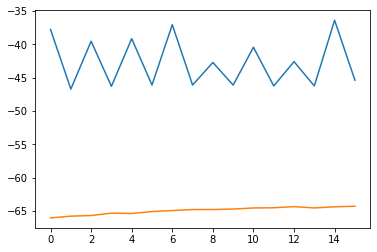

In [107]:
plt.plot(np.log(error_history_1))
plt.plot(np.log(error_history_2))